In [121]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd

# Load Dataset From Disk

In [122]:
def load_imdb_data(data_filie, size):
    df = pd.read_csv(data_filie)
    df = df[1: size]
    texts = df['text'].tolist()
    labels = [1 if sentiment == 'design' else 0 for sentiment in df['label'].tolist()]
    return texts, labels

texts, labels = load_imdb_data('./combined_raw.csv', 20)

In [123]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', 
                                  max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label)}



In [124]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 5

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer,  max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [125]:
# read sample data
train_data_iter = iter(train_dataloader)
sample_text = next(train_data_iter)

In [126]:
print(sample_text)

{'input_ids': tensor([[  101,  2208,  2701,  2215,  5335,  4751, 25037,  3291,  9260,  2695,
          2701,  2420,  2667,  7170,  2121,  2814,  2208,  2933,  5371, 10763,
          2345,  4118,  2465,  3565, 26266,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Construct the Classifier

In [127]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits


## Define Training and Evaluation Functions

In [128]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    prediction_probabilities = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_probab, preds = torch.max(outputs, dim=1)
            prediction_probabilities.extend(pred_probab.cpu().tolist())
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    auc_score = roc_auc_score(actual_labels, prediction_probabilities)
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), auc_score

In [129]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "design" if preds.item() == 1 else "general"

In [130]:
num_epochs = 4
learning_rate = 2e-5

In [131]:
if torch.backends.mps.is_available():
    device = torch.device("mps") 
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [132]:
model = BertClassifier(bert_model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

epochs = []
auc_scores = []
accuracy_scores = []



for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report, auc_score = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score}")
        auc_scores.append(auc_score)
        epochs.append(epoch)
        accuracy_scores.append(accuracy)
        print(report)



/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
Validation Accuracy: 0.2500
AUC Score: 1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.33      0.40         3

    accuracy                           0.25         4
   macro avg       0.25      0.17      0.20         4
weighted avg       0.38      0.25      0.30         4

Epoch 2/4


/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Validation Accuracy: 0.2500
AUC Score: 1.0
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         3

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4

Epoch 3/4


/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Validation Accuracy: 0.2500
AUC Score: 1.0
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         3

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4

Epoch 4/4
Validation Accuracy: 0.2500
AUC Score: 1.0
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         3

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4


/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [136]:
model_name = bert_model_name

results = {
    'epoch': epochs,
    'auc_score': auc_scores,
    'accuracy_score': accuracy_scores
}
results_df = pd.DataFrame(data=results)
results_df.to_csv(f"./results/{model_name}.csv", index=False)
results_df

,epoch,auc_score,accuracy_score
0,0,1.0,0.25
1,1,1.0,0.25
2,2,1.0,0.25
3,3,1.0,0.25


## Results Plotting

In [134]:
import matplotlib.pyplot as plt

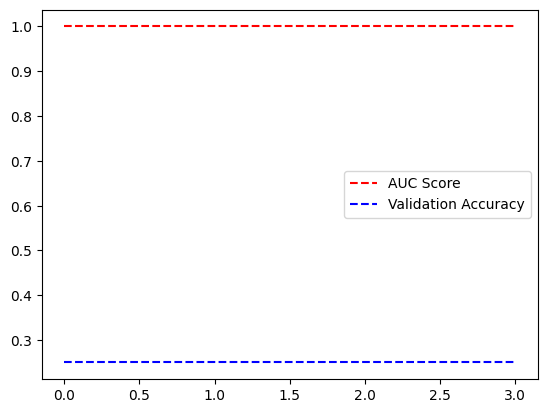

In [135]:
plt.plot(epochs, auc_scores, 'r--', epochs, accuracy_scores, 'b--')
plt.legend(['AUC Score', 'Validation Accuracy',])

## Next Steps

- early dropping
- saving model